In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import spacy

from gensim import models, corpora
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud
import locale
import multiprocessing

In [14]:
NUM_TOPICS = 20
NUM_PROCESS = max(1, multiprocessing.cpu_count() // 2)


In [15]:
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
with open(r"/content/cnn_articles.txt", 'r') as f:
    articles = f.read().split("@delimiter")

print(articles[0])
dataset = articles[:5000]

 -- Children in war-ravaged Afghanistan are safer than those growing up in London or New York, NATO's top civilian envoy says.

Mark Sedwill, the senior civilian representative for NATO, made the comments on an episode of CBBC's "Newsround," which is airing Monday.

In the show -- a BBC current-affairs program for children -- several youngsters in Kabul, Afghanistan, say they are afraid of daily violence and the frequent explosions in their war-torn country.

In response, Sedwill says: "Here in Kabul, and other big cities actually, there are very few of these bombs. The children are probably safer here than they would be in London, New York or Glasgow or many other cities.

"Most children can go about their lives in safety. It's a very family-oriented society. So it is a little bit like a city of villages," he added.

A U.N. report released earlier this year seems to contradict Sedwill's assessment.

The February report, by the special representative for children and armed conflict, sa

In [25]:
nlp_model = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define filtering function with POS and lemmatization
def lemmatize_and_filter(doc):
    return [
        token.lemma_
        for token in doc
        if token.is_alpha
        and not token.is_punct
        and not token.is_space
        and not token.is_stop
        and token.pos_ in ['NOUN', 'VERB', 'ADJ']
    ]

# Process and clean the dataset in parallel
cleaned_docs = list(
    map(lemmatize_and_filter, nlp_model.pipe(dataset, n_process=NUM_PROCESS))
)

# Create dictionary (vocabulary) from cleaned documents
vocab = corpora.Dictionary(cleaned_docs)

# Convert cleaned documents into Bag-of-Words format
bow_corpus = [vocab.doc2bow(doc) for doc in cleaned_docs]


In [26]:
lda_model = models.LdaModel(
    corpus=bow_corpus,
    id2word=vocab,
    num_topics=NUM_TOPICS,
    passes=10,
    alpha='auto',
    eta='auto',
    random_state=1
)

lda_model.print_topics()

[(0,
  '0.031*"government" + 0.026*"country" + 0.015*"group" + 0.013*"leader" + 0.010*"protest" + 0.010*"political" + 0.010*"say" + 0.009*"people" + 0.008*"protester" + 0.008*"violence"'),
 (1,
  '0.013*"city" + 0.010*"hotel" + 0.009*"room" + 0.009*"art" + 0.009*"building" + 0.008*"museum" + 0.007*"design" + 0.007*"dog" + 0.006*"house" + 0.006*"visit"'),
 (2,
  '0.015*"phone" + 0.013*"company" + 0.012*"food" + 0.011*"new" + 0.010*"user" + 0.008*"device" + 0.008*"internet" + 0.008*"site" + 0.008*"app" + 0.008*"use"'),
 (3,
  '0.024*"win" + 0.016*"player" + 0.016*"game" + 0.015*"play" + 0.014*"match" + 0.014*"season" + 0.013*"year" + 0.013*"second" + 0.013*"minute" + 0.013*"team"'),
 (4,
  '0.051*"say" + 0.011*"police" + 0.011*"tell" + 0.009*"year" + 0.009*"report" + 0.007*"case" + 0.007*"charge" + 0.007*"accord" + 0.006*"man" + 0.006*"authority"'),
 (5,
  '0.030*"say" + 0.013*"flight" + 0.012*"plane" + 0.010*"passenger" + 0.008*"crash" + 0.007*"pilot" + 0.007*"air" + 0.007*"fly" + 0.006

In [27]:
print(f"Dictionary size before filtering: {len(vocab)}")

vocab.filter_extremes(no_below=5, no_above=0.5)

print(f"Dictionary size after filtering: {len(vocab)}")

Dictionary size before filtering: 25217
Dictionary size after filtering: 10635


In [28]:
bow_corpus_filtered = [
    vocab.doc2bow(doc) for doc in cleaned_docs
]

lda_model = models.LdaModel(
    corpus=bow_corpus_filtered,
    id2word=vocab,
    num_topics=NUM_TOPICS,
    passes=10,
    alpha='auto',
    eta='auto',
    random_state=1
)

for idx, topic in lda_model.print_topics():
    print(f"Topic #{idx}: {topic}")

Topic #0: 0.011*"patient" + 0.011*"doctor" + 0.011*"child" + 0.010*"hospital" + 0.010*"care" + 0.009*"day" + 0.008*"medical" + 0.008*"health" + 0.008*"help" + 0.007*"die"
Topic #1: 0.026*"site" + 0.026*"phone" + 0.022*"video" + 0.018*"internet" + 0.017*"user" + 0.017*"use" + 0.013*"online" + 0.013*"social" + 0.013*"web" + 0.013*"app"
Topic #2: 0.017*"charge" + 0.012*"case" + 0.012*"family" + 0.011*"report" + 0.010*"death" + 0.009*"accord" + 0.008*"find" + 0.007*"prosecutor" + 0.007*"attorney" + 0.007*"court"
Topic #3: 0.017*"country" + 0.013*"war" + 0.013*"child" + 0.009*"government" + 0.008*"peace" + 0.007*"city" + 0.006*"international" + 0.006*"group" + 0.006*"violence" + 0.006*"conflict"
Topic #4: 0.017*"government" + 0.015*"official" + 0.015*"attack" + 0.014*"military" + 0.011*"report" + 0.011*"group" + 0.010*"kill" + 0.010*"force" + 0.009*"security" + 0.008*"country"
Topic #5: 0.015*"think" + 0.014*"know" + 0.012*"want" + 0.011*"go" + 0.010*"woman" + 0.010*"life" + 0.009*"man" + 0

In [29]:
print(lda_model.alpha)
print(lda_model.eta)

[0.07624973 0.03904925 0.07081781 0.05191035 0.08714226 0.122654
 0.10568646 0.03988149 0.04332017 0.05062692 0.0790511  0.07072783
 0.04061345 0.03389539 0.06406333 0.10674836 0.03905281 0.0544965
 0.0609486  0.04688   ]
[0.08999414 0.08673164 0.05073401 ... 0.04147914 0.04147917 0.04147916]


In [35]:
article_idx = 0
print(dataset[article_idx][:300])
topics = sorted(lda_model.get_document_topics(bow_corpus_filtered[article_idx]), key=lambda tup: tup[1])[::-1]
topics

 -- Children in war-ravaged Afghanistan are safer than those growing up in London or New York, NATO's top civilian envoy says.

Mark Sedwill, the senior civilian representative for NATO, made the comments on an episode of CBBC's "Newsround," which is airing Monday.

In the show -- a BBC current-affa


[(4, 0.45923984),
 (3, 0.29232317),
 (5, 0.15317544),
 (0, 0.053271),
 (16, 0.03574195)]

In [41]:
# View the words of the first prevalent topic from the previous article.
print(lda_model.show_topic(topics[0][0]))

# View the words of the second-most prevalent topic from the previous article.
print(lda_model.show_topic(topics[1][0]))

[('government', 0.017385868), ('official', 0.015178888), ('attack', 0.0151700955), ('military', 0.014309931), ('report', 0.010911893), ('group', 0.010644652), ('kill', 0.010356923), ('force', 0.010322093), ('security', 0.009313154), ('country', 0.008032287)]
[('country', 0.016532073), ('war', 0.012877332), ('child', 0.012691718), ('government', 0.00897134), ('peace', 0.0075934995), ('city', 0.006522202), ('international', 0.0061890865), ('group', 0.0061095553), ('violence', 0.006057002), ('conflict', 0.006027592)]


In [43]:
import pandas as pd

def get_dominant_topics_for_article(doc_index, min_prob=0.01):

    # Get topic distribution for the document, sorted by probability
    topic_distribution = sorted(
        lda_model.get_document_topics(bow_corpus_filtered[doc_index], minimum_probability=min_prob),
        key=lambda pair: pair[1],
        reverse=True
    )

    # Extract top words for each topic
    topic_keywords = [
        [word for word, _ in lda_model.show_topic(topic_id)]
        for topic_id, _ in topic_distribution
    ]

    # Build result as a DataFrame
    topic_summary = pd.DataFrame({
        'Topic ID & Probability': topic_distribution,
        'Top Words': topic_keywords
    })

    return topic_summary


In [46]:
pd.set_option('max_colwidth', 600)
text_preview_length = 500
min_topic_weight = 0.25
doc_index = 1

print("Document Preview:\n")
print(dataset[doc_index][:text_preview_length])

get_dominant_topics_for_article(doc_index, min_prob=min_topic_weight)


Document Preview:


 -- The Hard Rock Cafe franchise, famed for its rock'n'roll memorabilia, is expanding its reach into hotels and casinos -- but its chief executive says the brand will remain "special."

"We don't want to be in every street corner, in every city of the UK," Hard Rock's Hamish Dodds told CNN.

"We want to have a few very special locations, and keep it special," the 55-year-old Scotsman said from his office in Orlando, Florida.

The first Hard Rock Cafe opened in London in 1971, and in the 1980s t


,Topic ID & Probability,Top Words
0,"(15, 0.43500093)","[film, star, music, movie, new, good, play, song, work, world]"


In [47]:
doc_index = 10
print("Document Preview:\n")
print(dataset[doc_index][:text_preview_length])

get_dominant_topics_for_article(doc_index, min_prob=min_topic_weight)

Document Preview:


 -- The House Republican leadership upped the ante Thursday in the ongoing debate over the size and scope of the federal budget, unveiling a proposal to cut spending by $375 billion over the next five years.

House GOP Minority Whip Eric Cantor has been an outspoken critic of Democratic budget proposals.

The bulk of the GOP's proposed savings would come from capping nondefense discretionary spending at the level of inflation.

Among other things, the GOP proposal would also create a government


,Topic ID & Probability,Top Words
0,"(18, 0.9924077)","[government, plan, money, economy, pay, economic, tax, bill, cut, deal]"


In [50]:
coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=cleaned_docs,
    dictionary=vocab,
    coherence='u_mass'
)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score (U_mass): ', coherence_lda)

coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=cleaned_docs,
    dictionary=vocab,
    coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: (c_v)', coherence_lda)



Coherence Score (U_mass):  -1.6425496147968428

Coherence Score: (c_v) 0.5268025630325786


In [53]:
def display_topic_wordclouds(lda_model, num_rows, num_cols, max_words=30):

    wordcloud = WordCloud(
        background_color='white',
        max_words=max_words,
        prefer_horizontal=1.0
    )

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    axes = axes.flatten()

    for topic_index, ax in enumerate(axes):
        if topic_index >= lda_model.num_topics:
            ax.axis('off')
            continue

        topic_term_weights = dict(lda_model.show_topic(topic_index))
        wordcloud.generate_from_frequencies(topic_term_weights)

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"Topic {topic_index}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


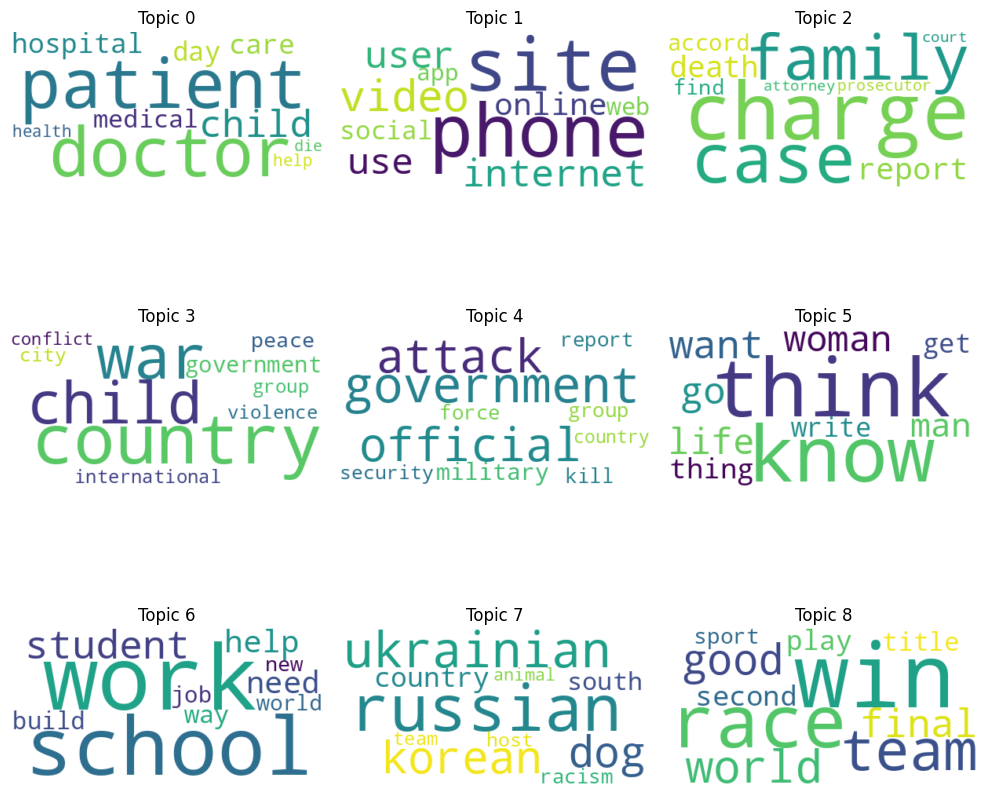

In [54]:
# Here we'll visualize the first nine topics.
display_topic_wordclouds(lda_model, 3, 3, 10)

In [55]:
similarity_index = similarities.MatrixSimilarity(
    lda_model[bow_corpus_filtered],
    num_features=len(vocab)
)

def find_similar_documents(bow_vector, lda_model, similarity_index, documents, top_n=5, preview_chars=300):

    topic_distribution = lda_model[bow_vector]
    similarities_scores = similarity_index[topic_distribution]

    ranked = sorted(enumerate(similarities_scores), key=lambda x: -x[1])[1:top_n + 1]
    return [(doc_id, round(score, 3), documents[doc_id][:preview_chars]) for doc_id, score in ranked]


In [67]:
doc_index = 1
print(f"\n Target Document #{doc_index} Preview:\n")
print(dataset[doc_index][:100])

find_similar_documents(
    bow_vector=bow_corpus_filtered[doc_index],
    lda_model=lda_model,
    similarity_index=similarity_index,
    documents=dataset,
    top_n=5
)

for i, (doc_id, score, preview) in enumerate(similar_docs, 1):
   print(f"#{i}: Doc {doc_id} | Similarity: {score:.3f}")
   print(f"    Preview: {preview.strip()[:text_preview_length]}\n")



 Target Document #1 Preview:


 -- The Hard Rock Cafe franchise, famed for its rock'n'roll memorabilia, is expanding its reach int
#1: Doc 4439 | Similarity: 1.000
    Preview: -- China's economy grew by 8.7 percent in 2009, according to the National Bureau of Statistics.

China's fourth quarter growth alone surged to 10.7 percent on an annualized basis.

China's economy has been picking up pace the first three quarters of the year, growing at 6.2 percent the first quarter and 7.9 percent the second quarter and 9.1 percent in the third quarter.

The gross domestic product total was $4.9 trillion in 2009. The annual growth was spurred by a $586 billion stimulus packag

#2: Doc 3006 | Similarity: 1.000
    Preview: -- The wealthy will account for more tax revenue, House Speaker John Boehner said Wednesday, while challenging President Barack Obama to sit down with him to hammer out a deal for avoiding the fiscal cliff.

"We have got to cut spending and I believe it is appropriate to put 

In [68]:
doc_index = 10

print(f"\n Target Document #{doc_index} Preview:\n")
print(dataset[doc_index][:text_preview_length])
print("\n Top Similar Documents:\n")

similar_docs = find_similar_documents(
    bow_vector=bow_corpus_filtered[doc_index],
    lda_model=lda_model,
    similarity_index=similarity_index,
    documents=dataset,
    top_n=5,
    preview_chars=text_preview_length
)

# Print results nicely
for i, (doc_id, score, preview) in enumerate(similar_docs, 1):
   print(f"#{i}: Doc {doc_id} | Similarity: {score:.3f}")
   print(f"    Preview: {preview.strip()[:text_preview_length]}\n")


 Target Document #10 Preview:


 -- The House Republican leadership upped the ante Thursday in the ongoing debate over the size and scope of the federal budget, unveiling a proposal to cut spending by $375 billion over the next five years.

House GOP Minority Whip Eric Cantor has been an outspoken critic of Democratic budget proposals.

The bulk of the GOP's proposed savings would come from capping nondefense discretionary spending at the level of inflation.

Among other things, the GOP proposal would also create a government

 Top Similar Documents:

#1: Doc 4439 | Similarity: 1.000
    Preview: -- China's economy grew by 8.7 percent in 2009, according to the National Bureau of Statistics.

China's fourth quarter growth alone surged to 10.7 percent on an annualized basis.

China's economy has been picking up pace the first three quarters of the year, growing at 6.2 percent the first quarter and 7.9 percent the second quarter and 9.1 percent in the third quarter.

The gross domestic p

In [69]:
custom_text = (
    "TechNova Inc. has announced the launch of its latest AI-powered analytics platform designed "
    "for enterprise-level data visualization. The system, unveiled during their annual tech summit, "
    "aims to streamline decision-making processes across industries by integrating machine learning "
    "into traditional business intelligence workflows."
)

custom_tokens = lemmatize_and_filter(nlp_model(custom_text))
custom_bow = vocab.doc2bow(custom_tokens)

similar_docs = find_similar_documents(
    bow_vector=custom_bow,
    lda_model=lda_model,
    similarity_index=similarity_index,
    documents=dataset,
    top_n=5,
    preview_chars=300
)

print("Similar Documents to Custom AI/Business Article:\n")
for i, (doc_id, score, preview) in enumerate(similar_docs, 1):
    print(f"#{i}: Doc {doc_id} | Similarity: {score:.3f}")
    print(f"    Preview: {preview.strip()[:300]}\n")

Similar Documents to Custom AI/Business Article:

#1: Doc 2668 | Similarity: 0.977
    Preview: -- A new era in space exploration dawned Tuesday as a slender rocket shot into the dark Florida sky before sunrise, carrying the first private spacecraft bound for the International Space Station.

"We're now back on the brink of a new future, a future that embraces the innovation the private sect

#2: Doc 2772 | Similarity: 0.976
    Preview: -- The federal government may require automakers to road test cars to ensure the accuracy of gas mileage claims, the Environmental Protection Agency confirmed Tuesday.

Currently, the EPA road tests 10 to 15 percent of new vehicles every year, but the other 85% are tested by the car companies them

#3: Doc 894 | Similarity: 0.970
    Preview: Satellite images of North Korea's Yongbyon nuclear facility have again raised questions about whether the country has restarted its plutonium production reactor -- regarded by western experts as a key component in